In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from PIL import Image
import numpy as np
from io import BytesIO
import os



In [135]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [136]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [137]:
bp_genre.head()

,genre_id,genre_name,song_count,genre_url,updated_on
0,8,Hard Dance / Hardcore,178646,/genre/hard-dance-hardcore/8,2023-09-19 15:01:03
1,50,Nu Disco / Disco,157934,/genre/nu-disco-disco/50,2023-09-19 15:01:03
2,12,Deep House,897280,/genre/deep-house/12,2023-09-19 15:01:03
3,85,Bass / Club,20716,/genre/bass-club/85,2023-09-19 15:01:03
4,94,Electro (Classic / Detroit / Modern),19615,/genre/electro-classic-detroit-modern/94,2023-09-19 15:01:03


In [138]:
bp_track.drop(columns=['track_id', 'title', 'mix', 'is_remixed', 'release_date', 'track_url', 'duration', 'duration_ms', 'isrc', 'updated_on', 'is_matched_spot', 'subgenre_id', 'label_id', 'release_id'], inplace=True, axis=1)

In [139]:
bp_track.isnull().sum()

genre_id       0
bpm            0
key_id      6254
dtype: int64

In [140]:
bp_track = bp_track.dropna()

In [141]:
# Define your desired sample size for each class
sample_size = 5000  # Adjust this to your desired sample size

# Get the minimum count of samples available across all genres
min_count = bp_track['genre_id'].value_counts().min()

# Ensure the sample size does not exceed the minimum class size
sample_size_per_class = min(sample_size, min_count)

# Sample from each genre
bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)

# Display the balanced sample
bp_sample.head()

C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\2565442244.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)


,genre_id,bpm,key_id
0,1,94,12.0
1,1,117,2.0
2,1,128,9.0
3,1,86,17.0
4,1,87,13.0


In [142]:
features = bp_sample.drop(columns='genre_id')

In [143]:
X = features
y = bp_sample['genre_id']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [145]:
def train_and_evaluate_model(models):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    results = {}

    for model in models:
        model_scores = {}
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute each metric
        for metric_name, metric_function in metrics.items():
            if metric_name == 'ROC AUC':
                # For binary or multiclass classification, use the predict_proba method
                if hasattr(model, "predict_proba"):
                    y_pred_prob = model.predict_proba(X_test)
                    if y_pred_prob.shape[1] == 2:
                        # Binary classification case
                        score = metric_function(y_test, y_pred_prob[:, 1])
                    else:
                        # Multiclass case
                        score = metric_function(y_test, y_pred_prob, multi_class='ovr')
                else:
                    score = "N/A"  # In case model does not support predict_proba
            else:
                # For multiclass classification, use 'weighted' average
                if metric_name in ['Precision', 'Recall', 'F1 Score']:
                    score = metric_function(y_test, y_pred, average='weighted')
                else:
                    score = metric_function(y_test, y_pred)

            model_scores[metric_name] = score

        results[str(model)] = model_scores

    return results


In [146]:
models = [
    LogisticRegression(),               # Linear model
    RandomForestClassifier(),           # Ensemble of decision trees
    GradientBoostingClassifier(),       # Boosting method
    AdaBoostClassifier(),               # Boosting method
    BaggingClassifier(),                # Bagging method
    KNeighborsClassifier(),             # k-NN classifier
    DecisionTreeClassifier(),           # Simple decision tree
    ExtraTreesClassifier()
    ]
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined 

C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:26: Use

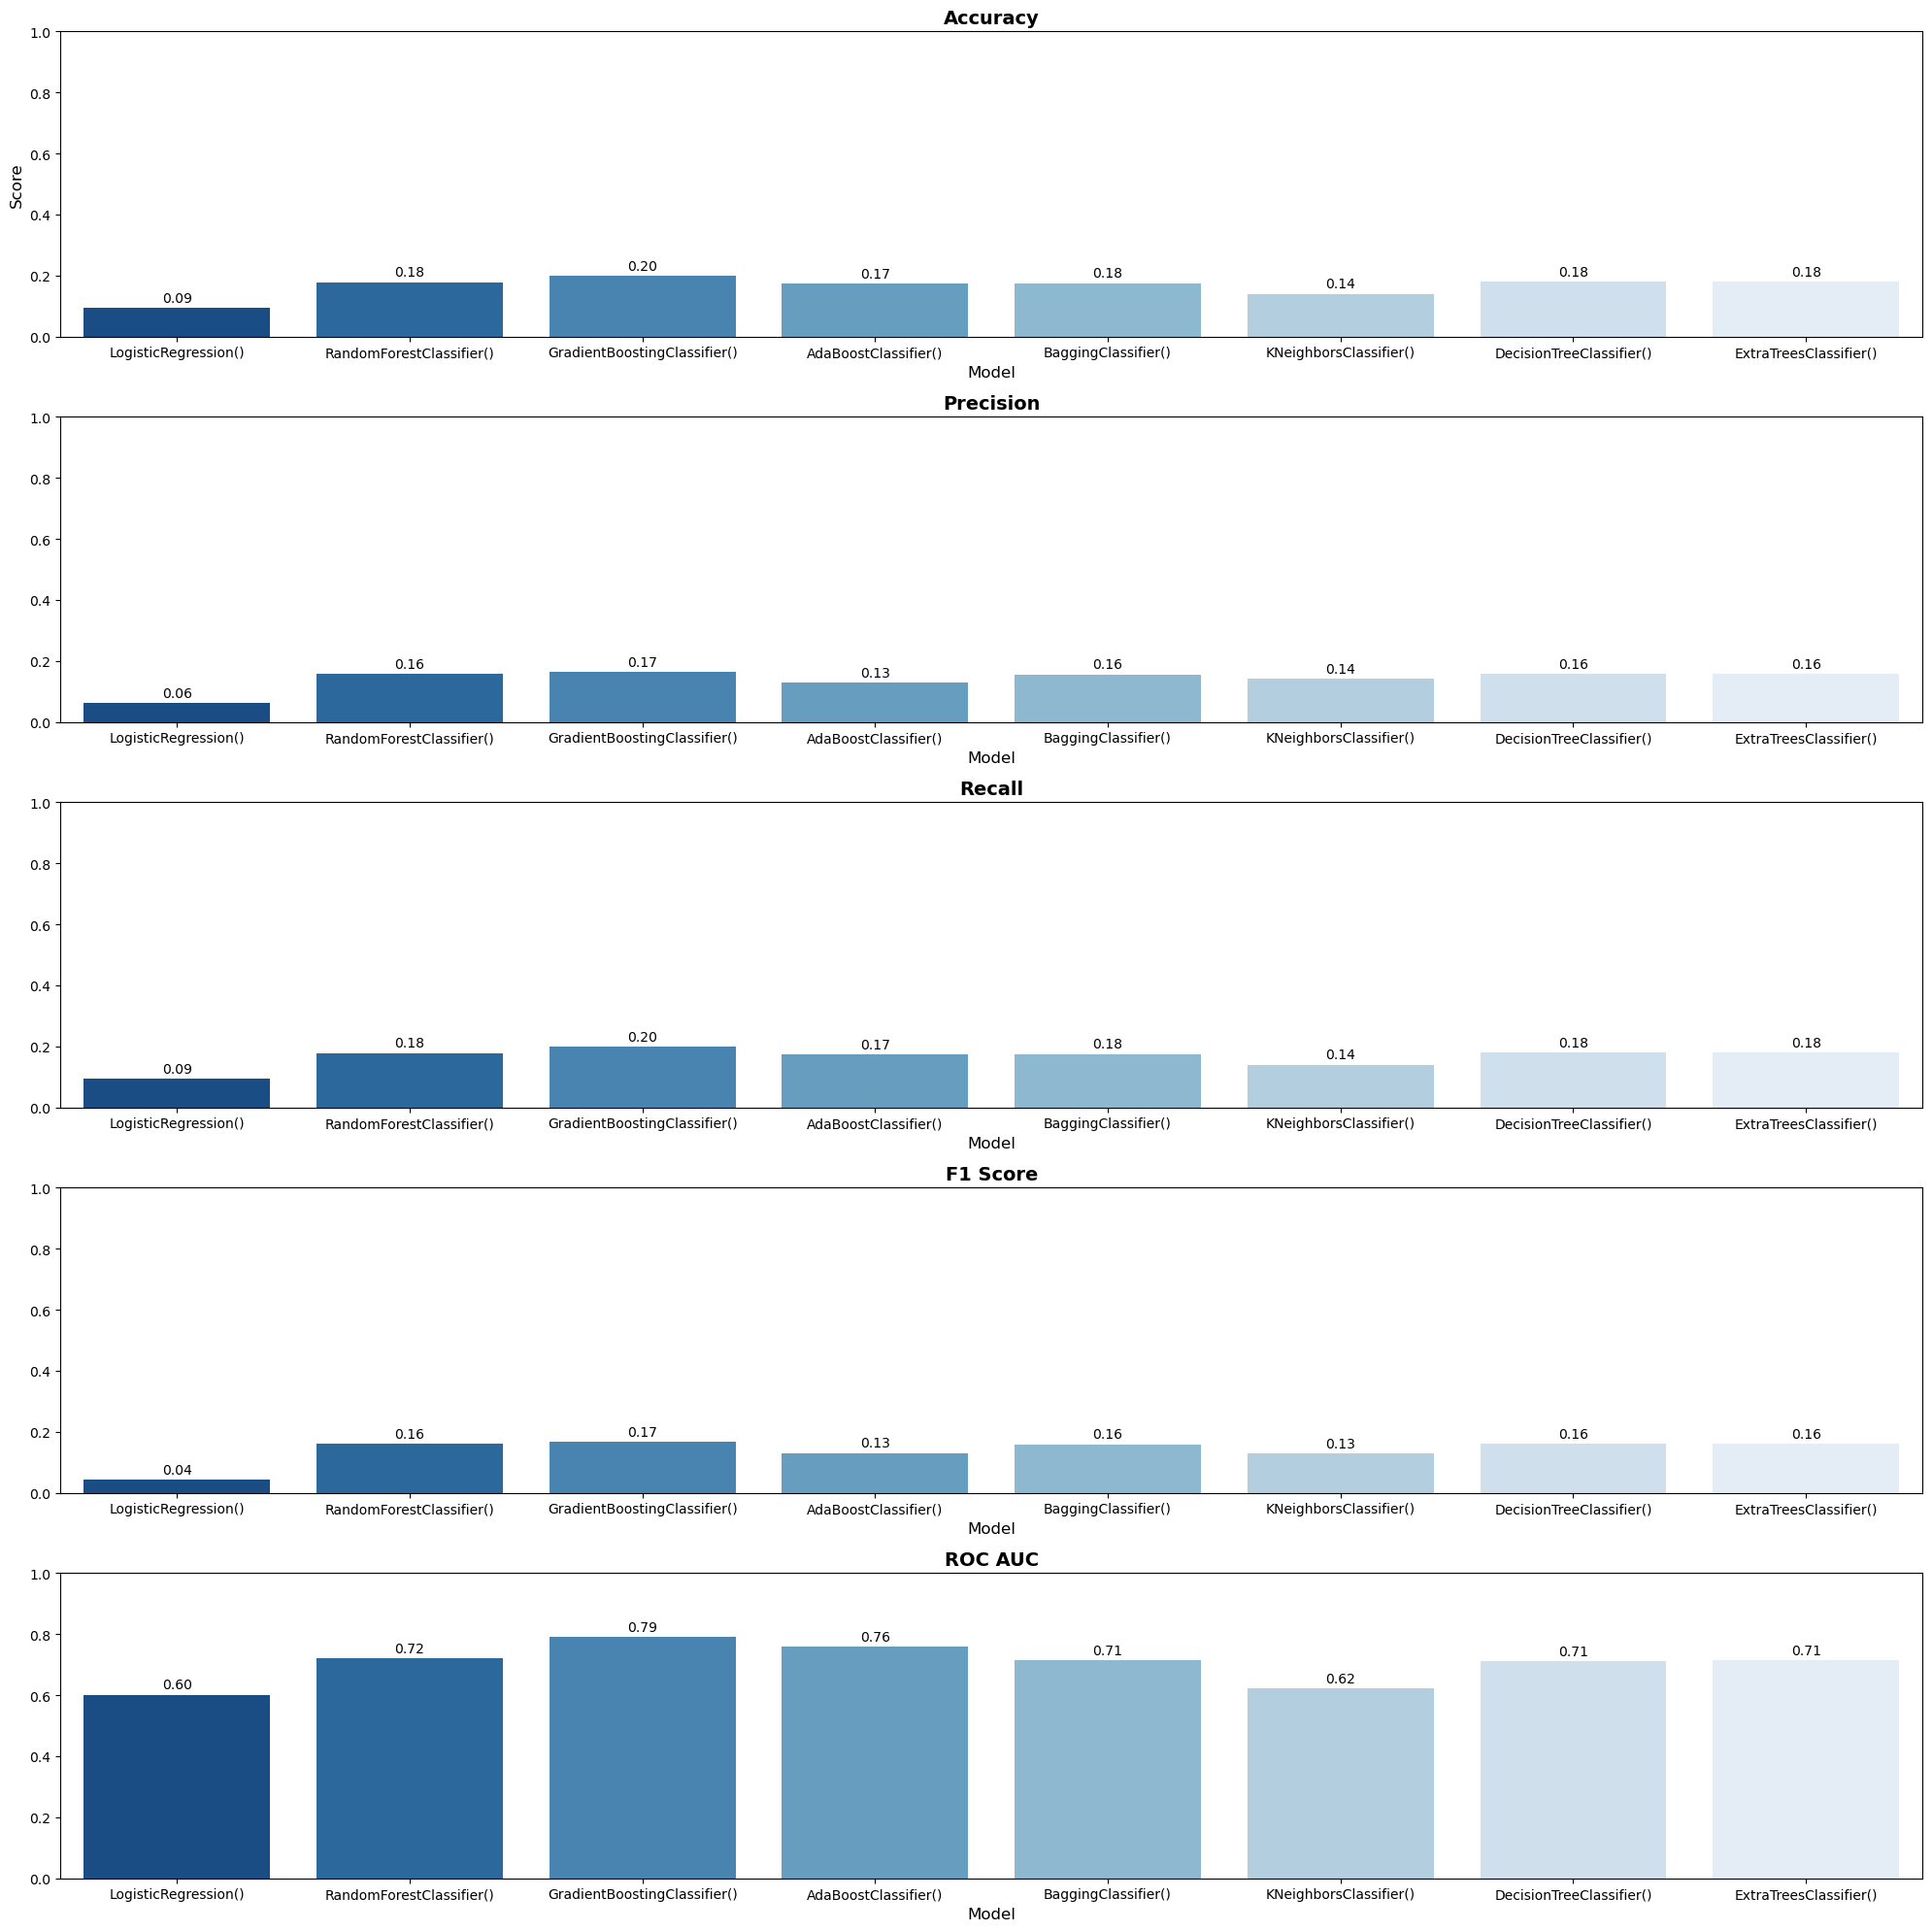

In [147]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


_________

# Manual Grouping

In [148]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [149]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

# Check the result
print(bp_genre[['genre_name', 'broad_genre']])

                              genre_name            broad_genre
0                  Hard Dance / Hardcore  Hard Dance & Hardcore
1                       Nu Disco / Disco              Dance/Pop
2                             Deep House                  House
3                            Bass / Club             Bass Music
4   Electro (Classic / Detroit / Modern)   Experimental & Indie
5                            Hard Techno                 Techno
6                                Dubstep             Bass Music
7             140 / Deep Dubstep / Grime             Bass Music
8                            Funky House                  House
9                      Progressive House                  House
10             Organic House / Downtempo      Downtempo & World
11                           Indie Dance   Experimental & Indie
12                            Afro House                  House
13                   Minimal / Deep Tech                 Techno
14                             Mainstage

In [150]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_track = pd.merge(bp_track, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_track.drop('genre_id', axis=1, inplace=True)

In [151]:
bp_track.isnull().sum()

bpm            0
key_id         0
broad_genre    0
dtype: int64

In [152]:
# Define your desired sample size for each class
sample_size = 5000  # Adjust this to your desired sample size

# Get the minimum count of samples available across all genres
min_count = bp_track['broad_genre'].value_counts().min()

# Ensure the sample size does not exceed the minimum class size
sample_size_per_class = min(sample_size, min_count)

# Sample from each genre
bp_sample = bp_track.groupby('broad_genre').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)

C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\990210175.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sample = bp_track.groupby('broad_genre').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)


In [153]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the broad_genre column
bp_sample['broad_genre_encoded'] = le.fit_transform(bp_sample['broad_genre'])

# Check the result
bp_sample.head()

,bpm,key_id,broad_genre,broad_genre_encoded
0,86,7.0,Bass Music,0
1,118,9.0,Bass Music,0
2,140,9.0,Bass Music,0
3,86,4.0,Bass Music,0
4,120,29.0,Bass Music,0


In [154]:
features = bp_sample.drop(columns=['broad_genre', 'broad_genre_encoded'])

In [155]:
X = features
y = bp_sample['broad_genre_encoded']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [157]:
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\391156369.py:26: Use

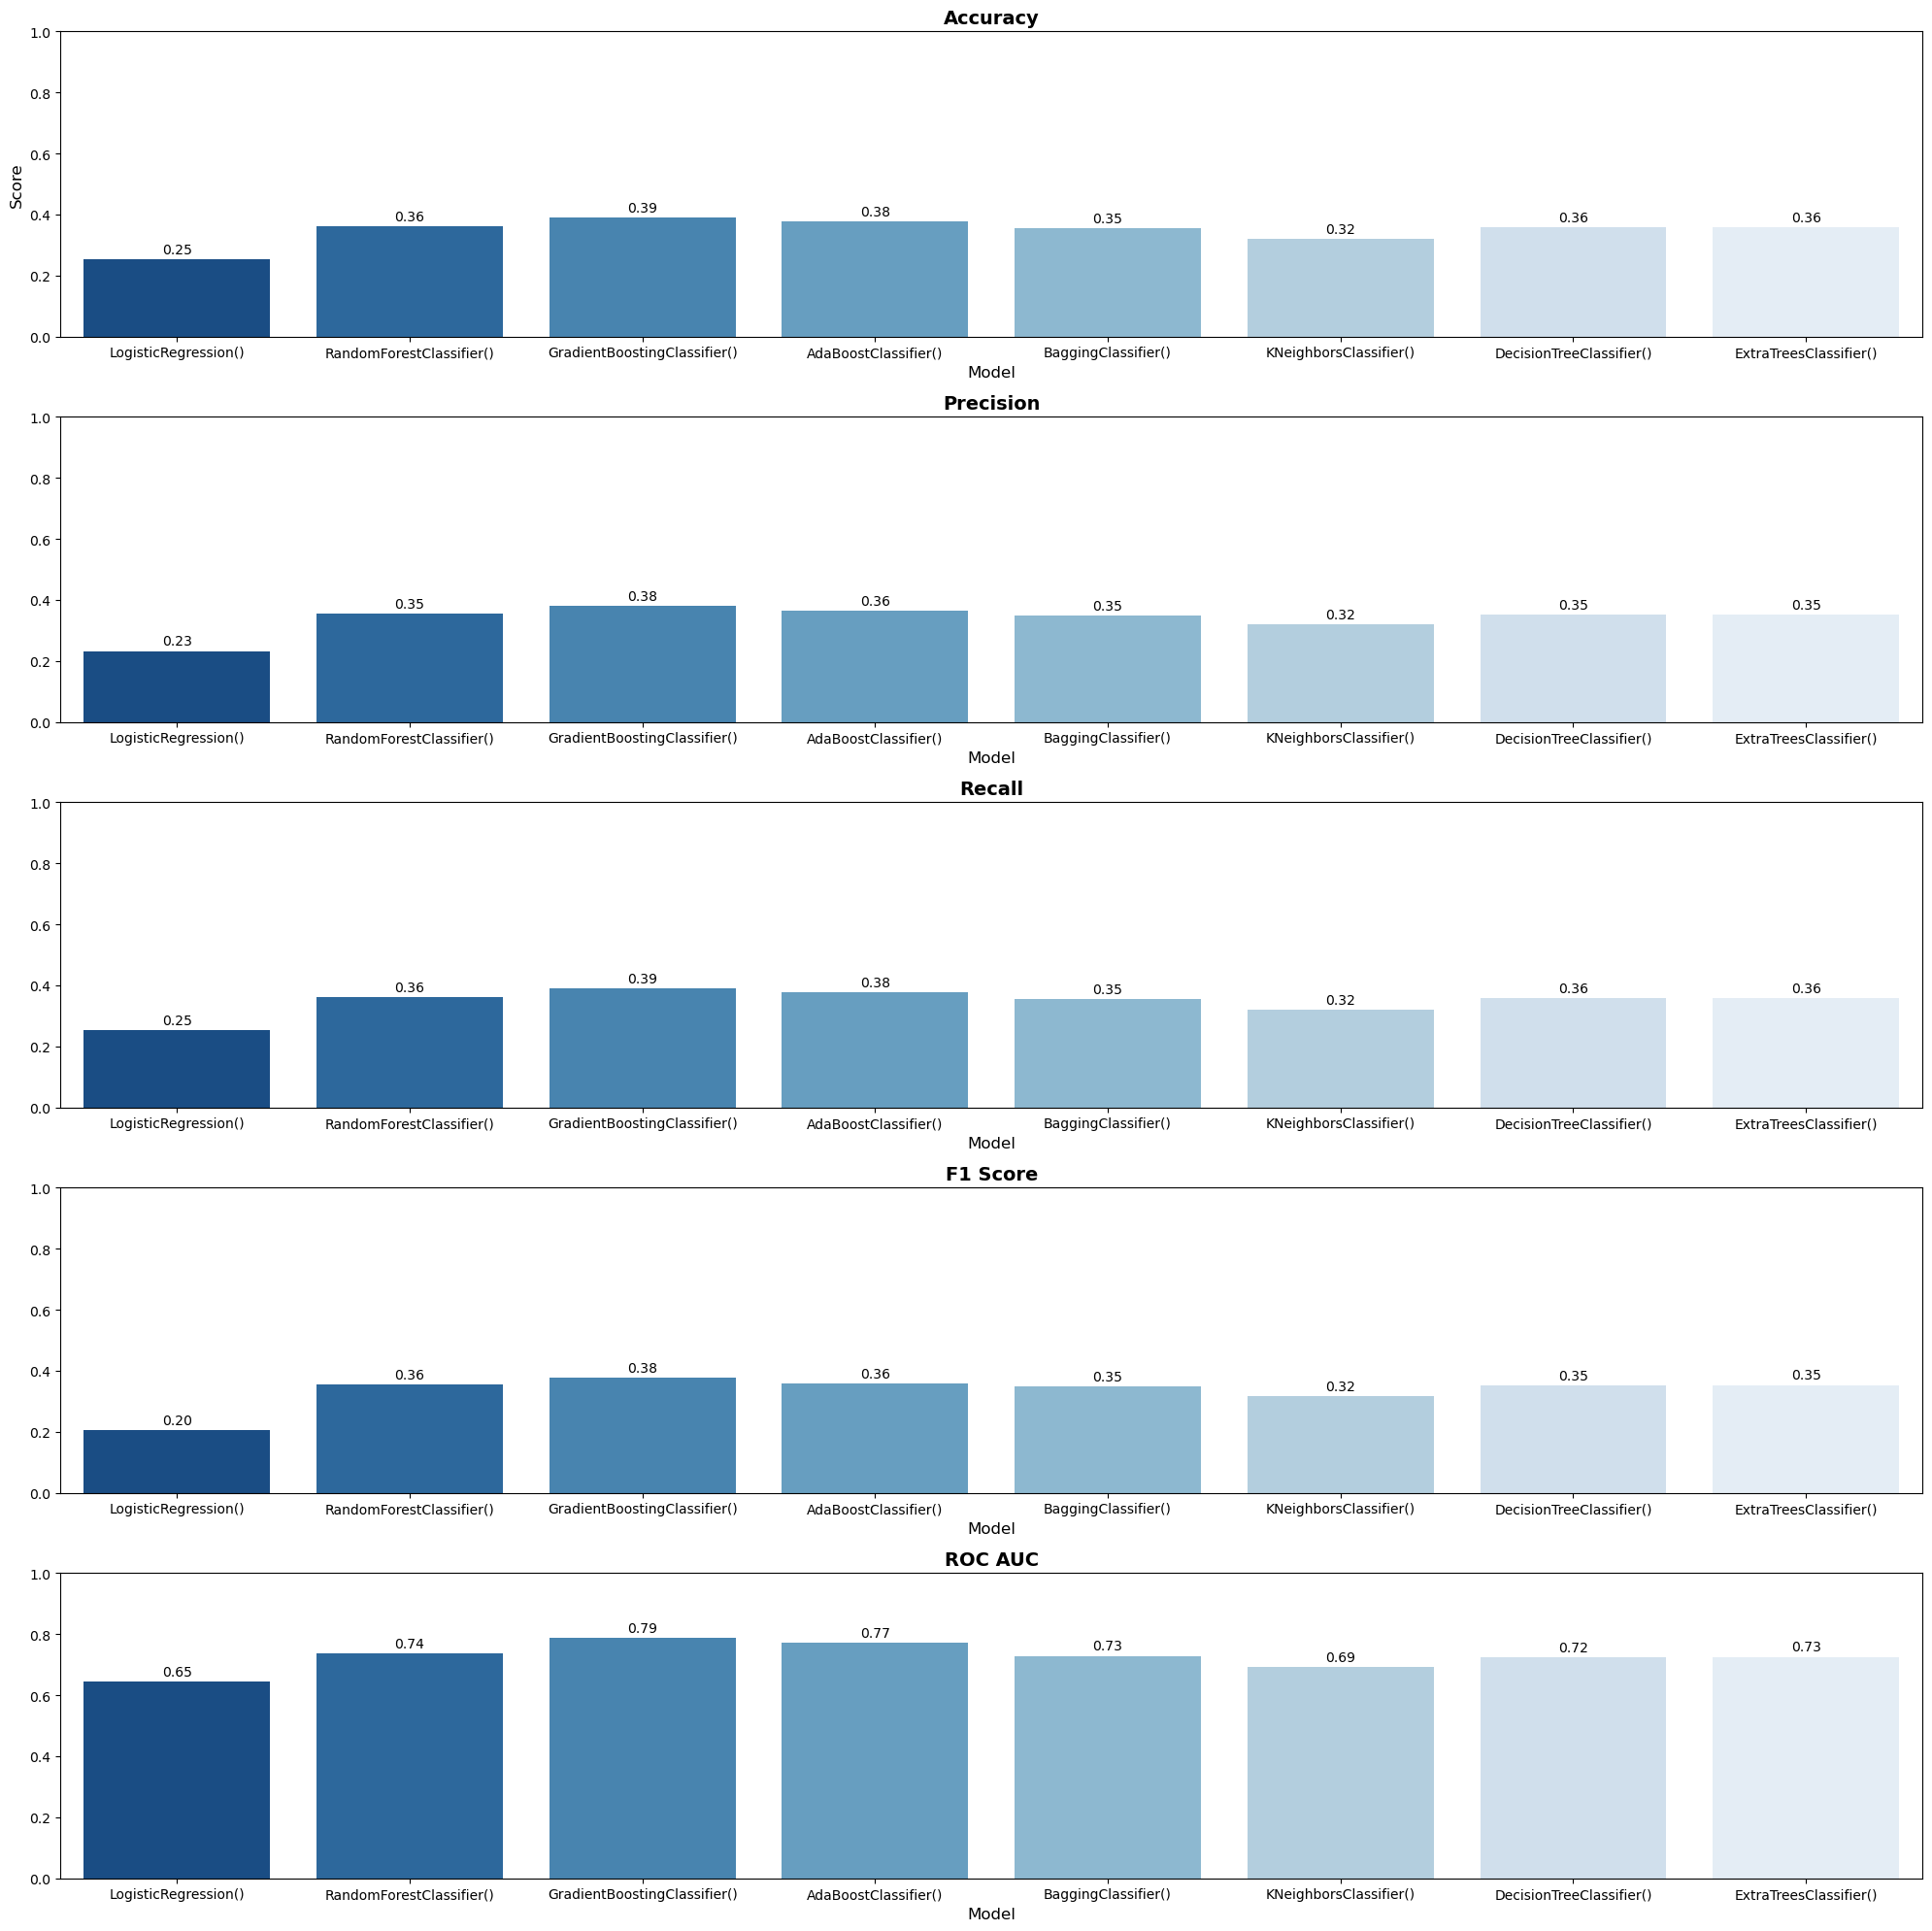

In [158]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


_________

# KMeans Clustering

In [159]:
bp_track.head()

,bpm,key_id,broad_genre
0,130,23.0,Trance
1,124,15.0,Trance
2,124,22.0,Trance
3,93,24.0,Trance
4,125,20.0,Trance


In [160]:
sampled_data = bp_track.sample(n=5000, random_state=42)

In [161]:
bp_clustering = sampled_data.drop(columns='broad_genre', axis=1)

In [162]:
scaler = StandardScaler()

bp_clustering = scaler.fit_transform(bp_clustering)

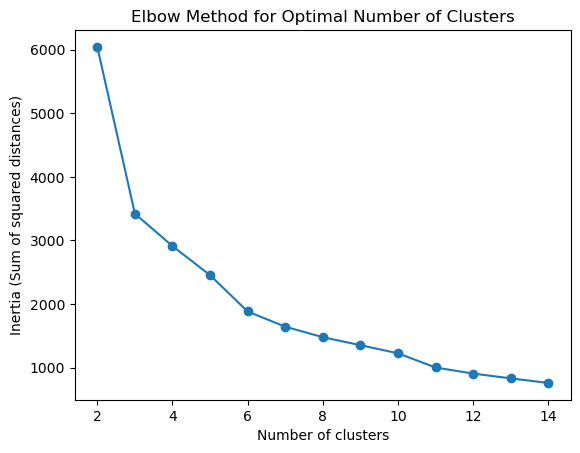

In [163]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Apply KMeans for a range of cluster numbers
inertia = []
cluster_range = range(2, 15)  # Try different numbers of clusters, from 2 to 15

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bp_clustering)
    inertia.append(kmeans.inertia_)

# Step 2: Plot the Elbow Curve
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

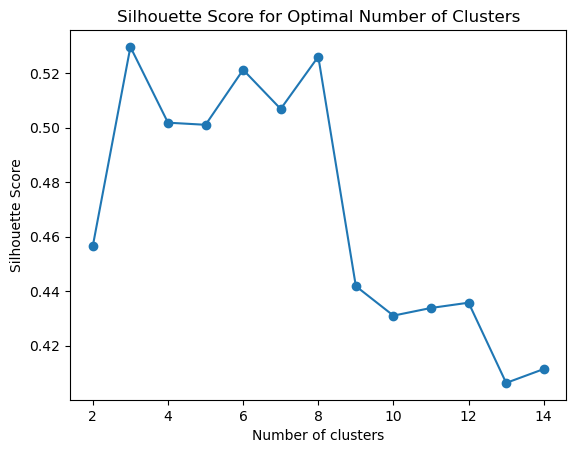

In [164]:
from sklearn.metrics import silhouette_score

# Step 1: Apply KMeans and compute Silhouette Scores for a range of cluster numbers
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(bp_clustering)
    silhouette_avg = silhouette_score(bp_clustering, clusters)
    silhouette_scores.append(silhouette_avg)

# Step 2: Plot Silhouette Scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [171]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(bp_clustering)

In [172]:
sil_score = silhouette_score(bp_clustering, clusters)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.5260805995957849


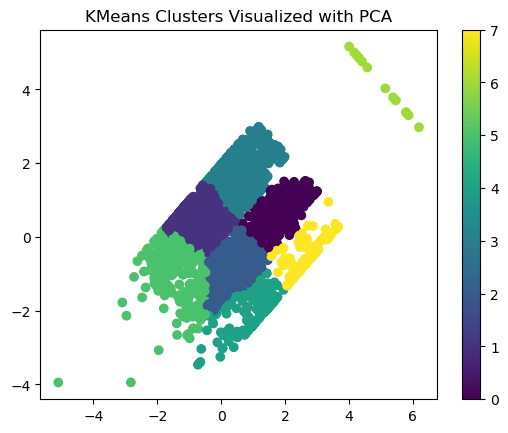

In [173]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensions of the data to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bp_clustering)

# Plot the clusters in 2D space
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clusters Visualized with PCA')
plt.show()

In [174]:
X = bp_clustering
y = clusters

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [175]:
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\2795128014.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\2795128014.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\2795128014.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_22808\2795128014.py:26:

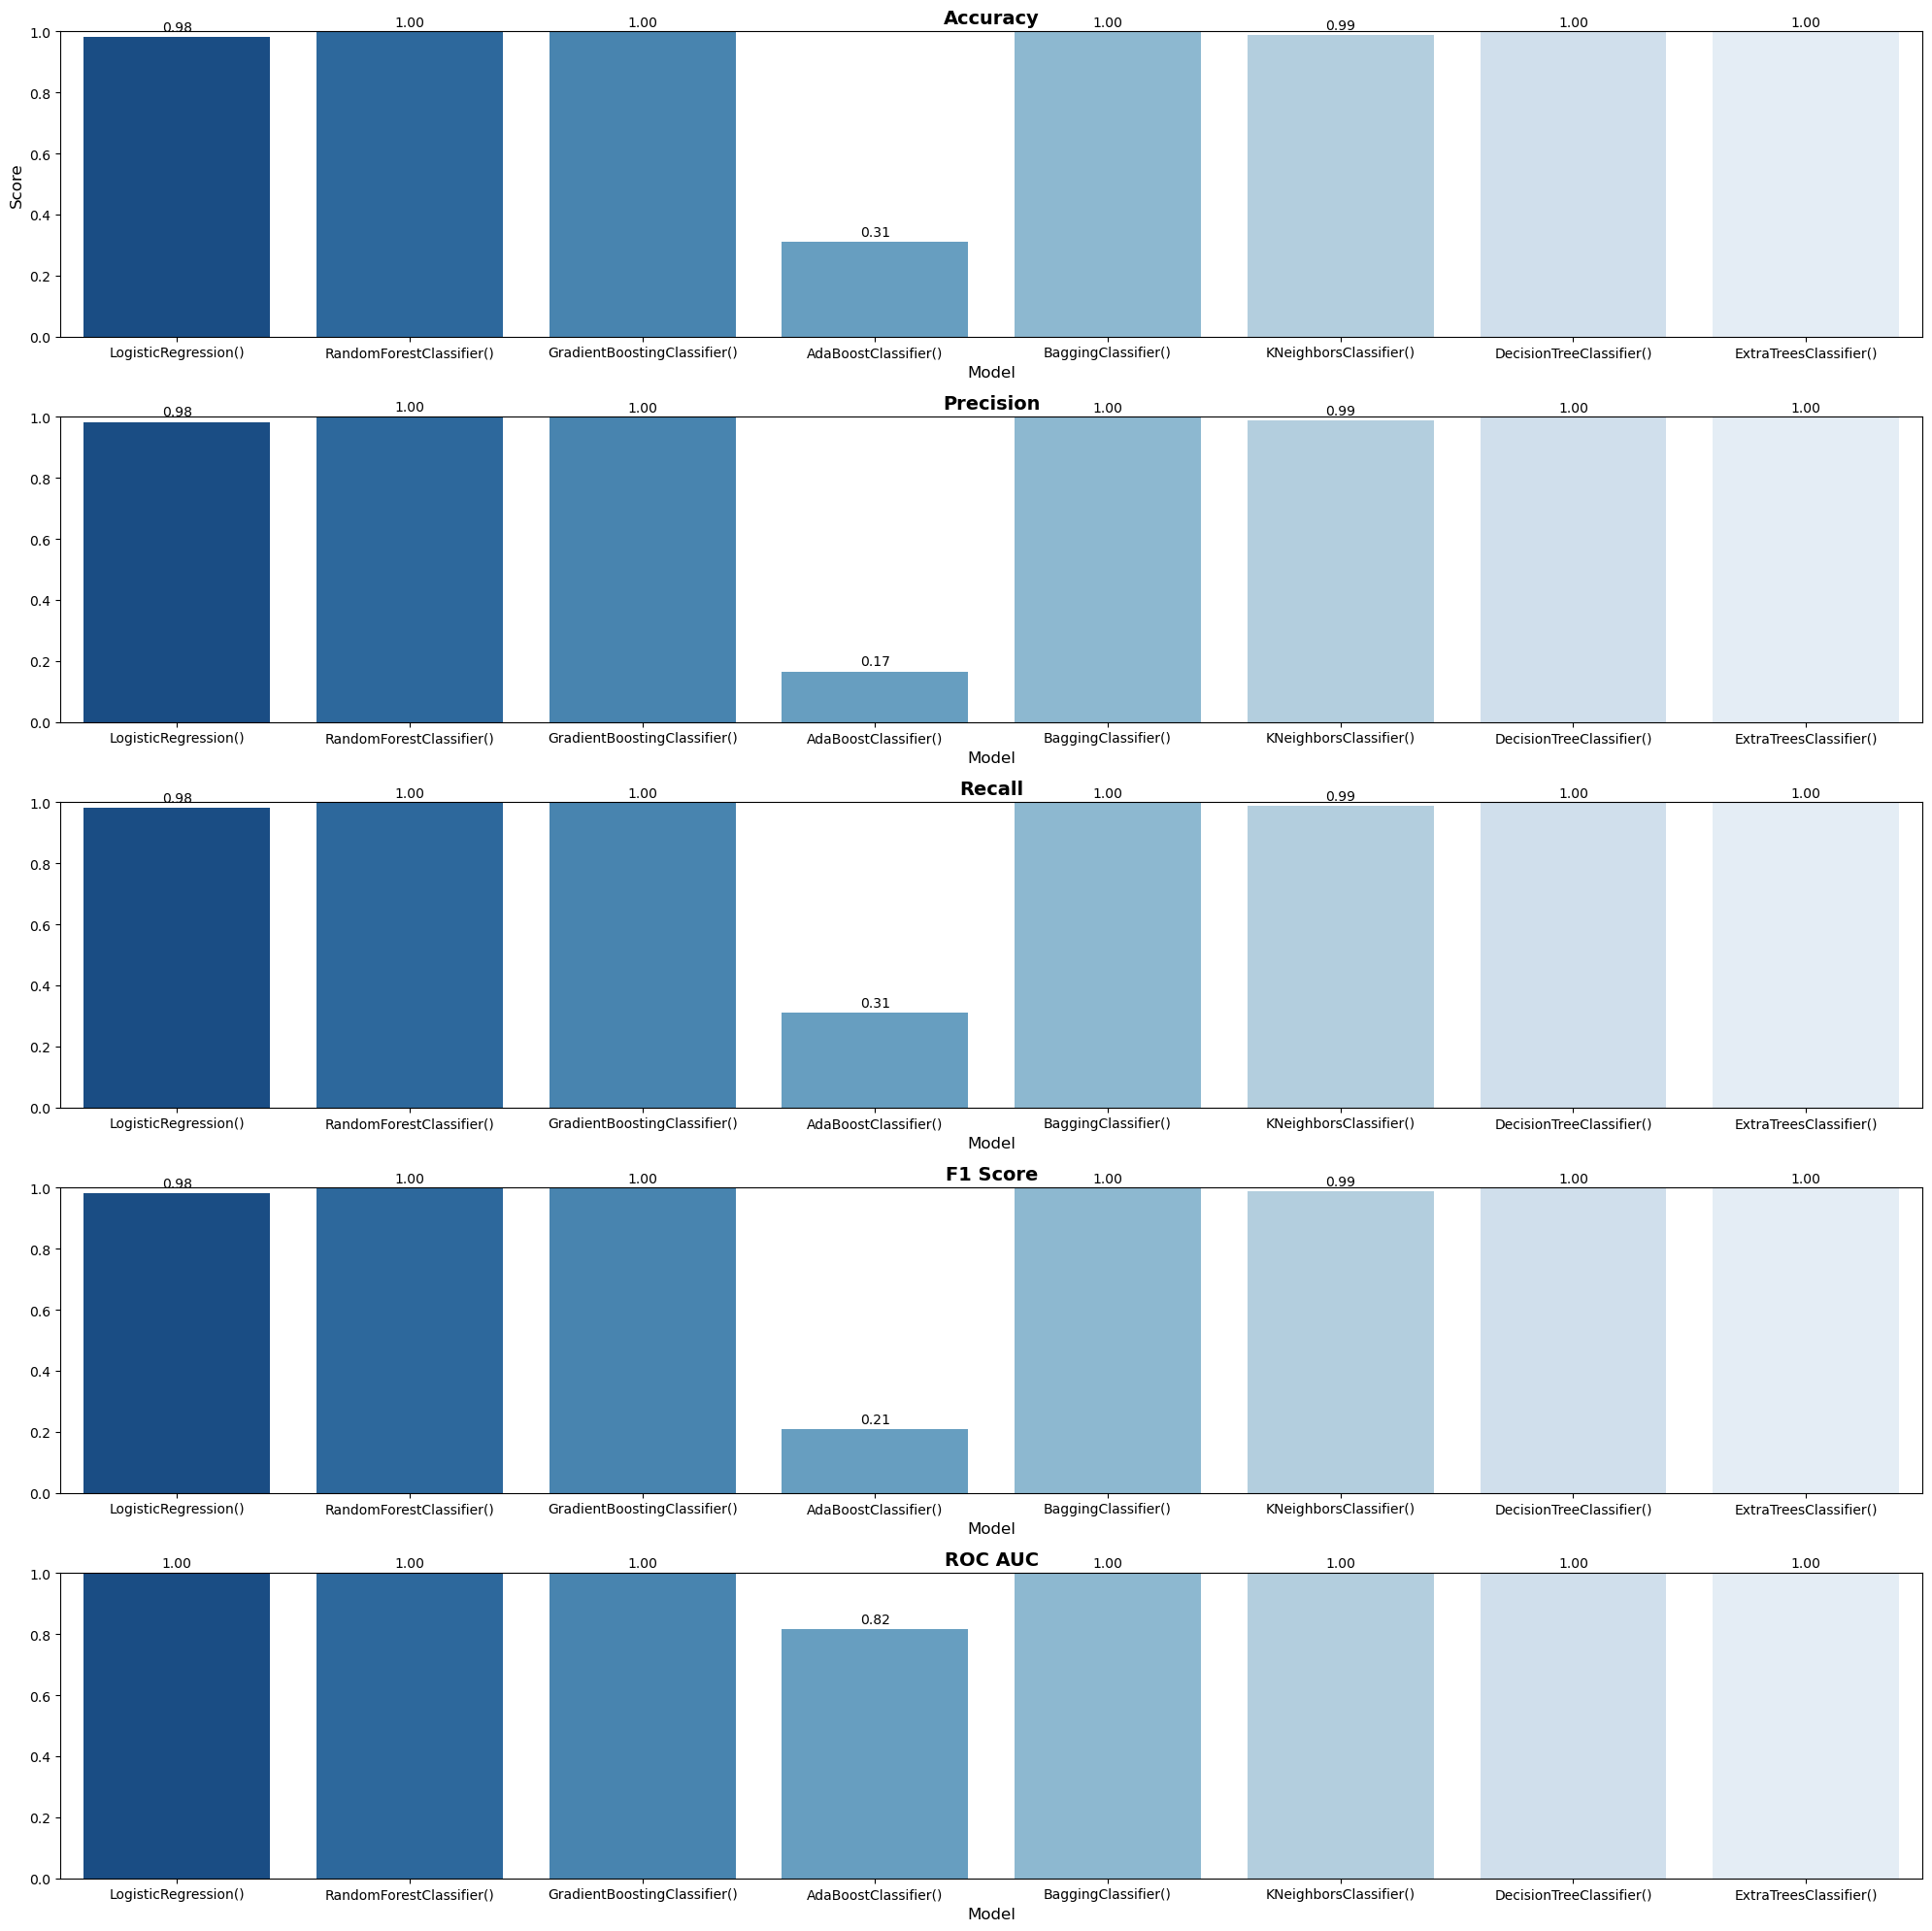

In [176]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()